In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

This notebook explores SGD parameters tuning 
1. Using constant learning rates in the range [1e-2, 1e-3]
2. Adding step decay schedule
3. Using Momntum settings [0.5,0.90,0.98]
4. Turning on nestrov = True

All these experiments are tuned for right number of epochs. The evaluation is smoothmenss of loss curve and out of set tests.
For all these experiments batch size is 32

In [2]:
import os
import shutil
import time
import datetime
import random

import numpy as np

from tensorflow.keras import layers,models,utils,optimizers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,LearningRateScheduler
from util.custom_callbacks import SkipLoggerCallback,StepDecayHistoryCallback
from util.custom_callbacks import step_decay

import matplotlib.pyplot as plt

In [3]:
DATA_DIR = 'data/caps_and_shoes_squared/'
IMAGE_SIZE = (28,28)
CLASS_LIST = ['cap','shoes']
BATCH_SIZE = 32

train_path = DATA_DIR + 'train'
validation_path = DATA_DIR + 'val'
test_path = DATA_DIR + 'test'

SOURCE_DATA_DIR = 'data/caps_and_shoes_squared_2/'
TEST_DATA_DIR = 'data/out_of_set_tests/'

In [4]:
def create_test_set(seed=random.randint(1,10000)):

    dirpath = os.path.join(TEST_DATA_DIR, 'temp_test')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        
    os.makedirs(dirpath, exist_ok=True)
    
    for class_name in CLASS_LIST:
        src_dir = os.path.join(SOURCE_DATA_DIR, class_name)
        dest_dir = os.path.join(dirpath, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        
        src_files = (os.listdir(src_dir))
        random.seed(seed)
        choices = random.sample(src_files, 25)
        for file_name in choices:
            shutil.copy(os.path.join(src_dir, file_name), dest_dir)
            
def get_oos_test_accuracy(model=None):
    
    out_test_accuracy_log = []
    
    for iter_count in range(25):
    
        seed = random.randint(1,10000)
        create_test_set(seed)

        test_img_generator = ImageDataGenerator(rescale = 1./255)
        test_batches = test_img_generator.flow_from_directory(os.path.join(TEST_DATA_DIR, 'temp_test'),
                                                              target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                              class_mode = 'categorical', batch_size=32)
        test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
        out_test_accuracy_log.append(test_accuracy)
    
    return (np.mean(out_test_accuracy_log),np.std(out_test_accuracy_log))

In [5]:
test_img_generator = ImageDataGenerator( rescale = 1./255)
train_validation_img_generator = ImageDataGenerator(validation_split=0.2, rescale = 1./255, rotation_range = 10, width_shift_range = 0.1, height_shift_range=0.1, zoom_range = 0.1, 
                                   horizontal_flip=True, fill_mode='nearest')

train_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='training')

validation_batches = train_validation_img_generator.flow_from_directory(train_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical', batch_size=BATCH_SIZE, subset='validation')

test_batches = test_img_generator.flow_from_directory(test_path, target_size=IMAGE_SIZE, classes=CLASS_LIST, color_mode = 'grayscale', 
                                                  class_mode = 'categorical',batch_size=1, shuffle=False)

Found 1832 images belonging to 2 classes.
Found 457 images belonging to 2 classes.
Found 326 images belonging to 2 classes.


In [6]:
def define_model_architecture_64_32_16(sgd_optimizer = 'sgd'):
    model = models.Sequential()
    model.add(Flatten(input_shape = (28,28,1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Tuning for static learning rates

In [7]:
learning_rates = [0.009,0.0066,0.003,0.002]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
EPOCHS = 600

In [8]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

#es_callback = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, min_delta=0.002, 
#                            restore_best_weights = True)

In [9]:
for learning_rate in learning_rates:
    print('working with learning rate : %f' % learning_rate)
    print('')
    
    sgd = optimizers.SGD(lr=learning_rate)
    model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = [skipLogger_callback, tb_callback])
    training_time_dict[str(learning_rate)] = time.time() - start
    learning_history_dict[str(learning_rate)] = history
    
    out_of_set_test_dict[str(learning_rate)] = get_oos_test_accuracy(model)
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)


working with learning rate : 0.009000



W0902 20:19:03.072762 140337221842752 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.682741    accuracy = 0.56    val_loss = 0.714685    val_accuracy = 0.57
epoch =   25    loss = 0.548702    accuracy = 0.73    val_loss = 0.577418    val_accuracy = 0.73
epoch =   50    loss = 0.503866    accuracy = 0.77    val_loss = 0.518146    val_accuracy = 0.76
epoch =   75    loss = 0.468697    accuracy = 0.79    val_loss = 0.490812    val_accuracy = 0.77
epoch =  100    loss = 0.464633    accuracy = 0.79    val_loss = 0.501193    val_accuracy = 0.77
epoch =  125    loss = 0.437351    accuracy = 0.81    val_loss = 0.483472    val_accuracy = 0.77
epoch =  150    loss = 0.431325    accuracy = 0.80    val_loss = 0.535991    val_accuracy = 0.72
epoch =  175    loss = 0.415466    accuracy = 0.81    val_loss = 0.458382    val_accuracy = 0.80
epoch =  200    loss = 0.385513    accuracy = 0.83    val_loss = 0.451262    val_accuracy = 0.82
epoch =  225    loss = 0.389724    accuracy = 0.83    val_loss = 0.381569    val_accuracy = 0.83
epoch =  250    loss = 0.38859

epoch =  300    loss = 0.420121    accuracy = 0.81    val_loss = 0.444143    val_accuracy = 0.81
epoch =  325    loss = 0.401977    accuracy = 0.82    val_loss = 0.463282    val_accuracy = 0.78
epoch =  350    loss = 0.404924    accuracy = 0.83    val_loss = 0.416290    val_accuracy = 0.84
epoch =  375    loss = 0.392655    accuracy = 0.83    val_loss = 0.432963    val_accuracy = 0.82
epoch =  400    loss = 0.380066    accuracy = 0.84    val_loss = 0.489671    val_accuracy = 0.79
epoch =  425    loss = 0.375947    accuracy = 0.83    val_loss = 0.433713    val_accuracy = 0.84
epoch =  450    loss = 0.389145    accuracy = 0.83    val_loss = 0.384374    val_accuracy = 0.84
epoch =  475    loss = 0.376957    accuracy = 0.83    val_loss = 0.457723    val_accuracy = 0.80
epoch =  500    loss = 0.367518    accuracy = 0.84    val_loss = 0.444316    val_accuracy = 0.80
epoch =  525    loss = 0.374358    accuracy = 0.83    val_loss = 0.406696    val_accuracy = 0.82
epoch =  550    loss = 0.37079

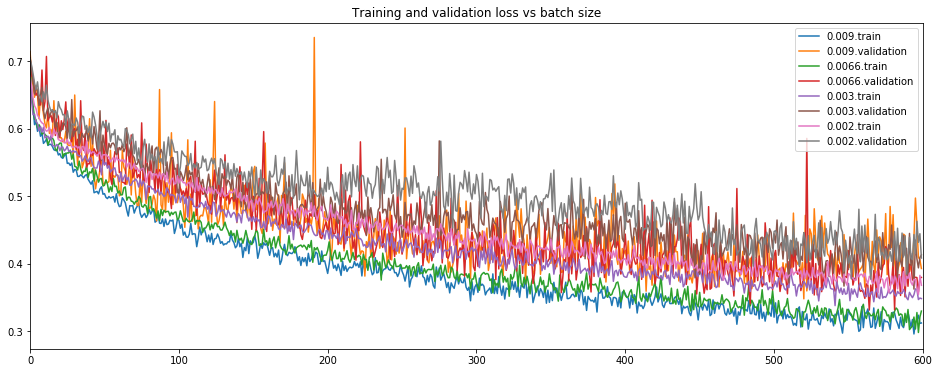

In [10]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= lr +'.train')
    plt.plot(training_history.history['val_loss'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

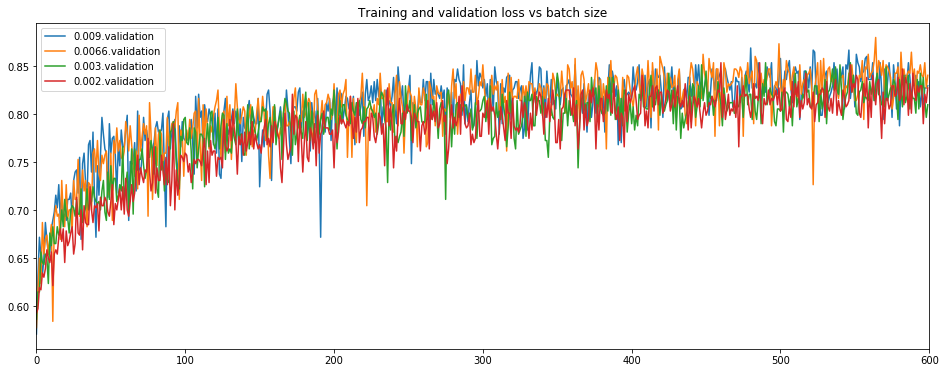

In [16]:
plt.figure(num=None, figsize=(16, 6))

for lr,training_history in learning_history_dict.items():
#    plt.plot(training_history.history['accuracy'], label= lr +'.train')
    plt.plot(training_history.history['val_accuracy'], label= lr + '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

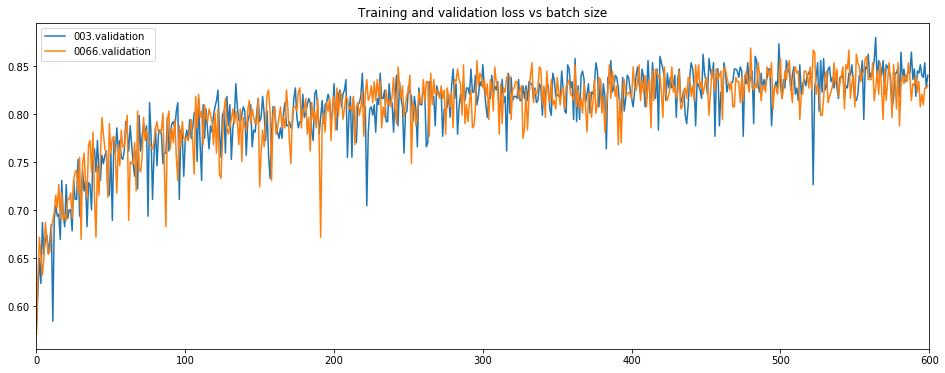

In [24]:
plt.figure(num=None, figsize=(16, 6))

#plt.plot(learning_history_dict['0.002'].history['accuracy'], label= lr +'.train')
plt.plot(learning_history_dict['0.0066'].history['val_accuracy'], label= '003.validation')
plt.plot(learning_history_dict['0.009'].history['val_accuracy'], label= '0066.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

In [12]:
training_time_dict

{'0.009': 3394.544312477112,
 '0.0066': 3405.4100835323334,
 '0.003': 3592.44495511055,
 '0.002': 3441.3910224437714}

In [13]:
out_of_set_test_dict

{'0.009': (0.8504979, 0.06668169),
 '0.0066': (0.8384435, 0.06049636),
 '0.003': (0.8408258, 0.058858592),
 '0.002': (0.8132408, 0.04722363)}

##### Observations
1. for learning rate = 0.009, 300 is where overfitting starts. after 500, performance deteriorates.
2. for learning rate = 0.0066, overfitting starts at 400
3. for learning rate = 0.003, overfitting starts at 250
4. for learning rate = 0.003, overfitting starts at 400

Overall 0.009 and 0066 are better learning rates. At 300, the rate should be slowed down significantly

### Step Decay

1. Setting 1 : EPOCHS 700,  initial_lrate = 1e-2, drop = 0.864065, epochs_drop = 25

In [12]:
from util.custom_callbacks import step_decay_100_864065
EPOCHS = 700

In [13]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay_100_864065)
lr_history_callback = StepDecayHistoryCallback()

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
callback_list = [lrate_callback, tb_callback, skipLogger_callback, lr_history_callback]

In [14]:
sgd =  optimizers.SGD(lr=0.0)
model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    
print('time taken for traning : %.4f' % (time.time() - start))
test_accuracy, test_acc_std_dev = get_oos_test_accuracy(model)
print('Test accuracy: %.4f std dev: %.4f' % (test_accuracy, test_acc_std_dev))    

test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
print('-'*120)

epoch =    0    loss = 0.645441    accuracy = 0.63    val_loss = 0.677713    val_accuracy = 0.60
epoch =   25    loss = 0.543715    accuracy = 0.73    val_loss = 0.557859    val_accuracy = 0.75
epoch =   50    loss = 0.510284    accuracy = 0.77    val_loss = 0.530891    val_accuracy = 0.77
epoch =   75    loss = 0.465055    accuracy = 0.78    val_loss = 0.500173    val_accuracy = 0.80
epoch =  100    loss = 0.449826    accuracy = 0.80    val_loss = 0.541063    val_accuracy = 0.74
epoch =  125    loss = 0.418919    accuracy = 0.82    val_loss = 0.489071    val_accuracy = 0.80
epoch =  150    loss = 0.423695    accuracy = 0.81    val_loss = 0.454939    val_accuracy = 0.82
epoch =  175    loss = 0.398043    accuracy = 0.82    val_loss = 0.464002    val_accuracy = 0.79
epoch =  200    loss = 0.397069    accuracy = 0.84    val_loss = 0.433328    val_accuracy = 0.83
epoch =  225    loss = 0.395131    accuracy = 0.83    val_loss = 0.431196    val_accuracy = 0.83
epoch =  250    loss = 0.38017

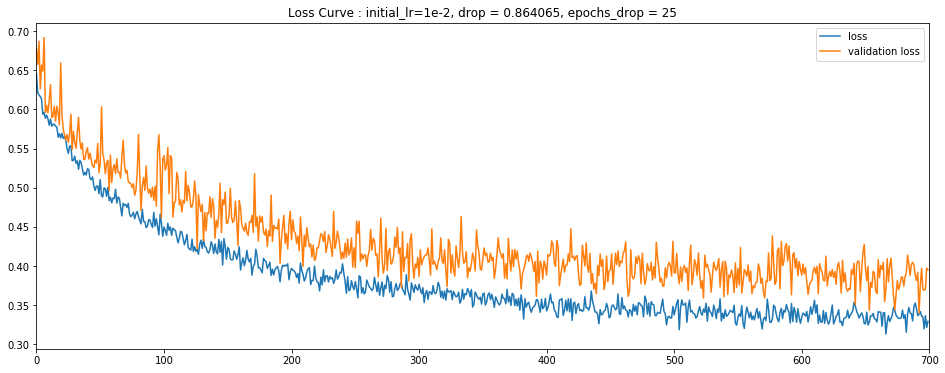

In [15]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation loss')

plt.legend()
plt.title('Loss Curve : initial_lr=1e-2, drop = 0.864065, epochs_drop = 25')
plt.xlim(0, EPOCHS)
plt.show()

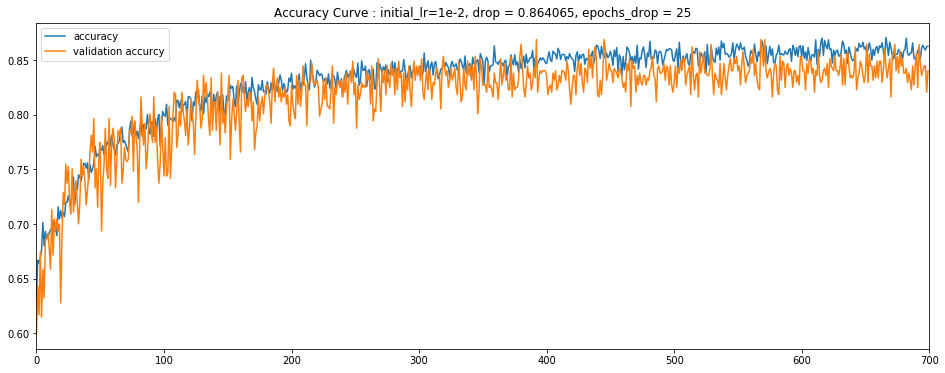

In [16]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accurcy')

plt.legend()
plt.title('Accuracy Curve : initial_lr=1e-2, drop = 0.864065, epochs_drop = 25')
plt.xlim(0, EPOCHS)
plt.show()

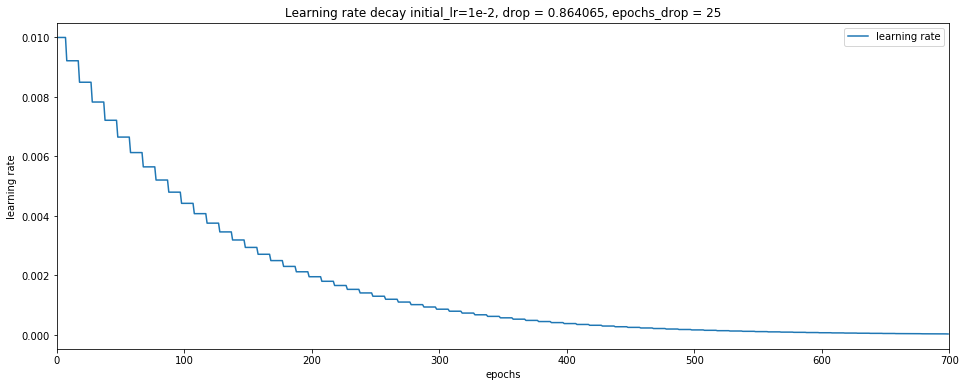

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(lr_history_callback.lr, label='learning rate')
plt.xlabel("epochs")
plt.xlim(0, EPOCHS)
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.title('Learning rate decay initial_lr=1e-2, drop = 0.864065, epochs_drop = 25')
plt.show()

In [8]:
from util.custom_callbacks import step_decay_100_599484
EPOCHS = 600

In [9]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay_100_599484)
lr_history_callback = StepDecayHistoryCallback()

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
callback_list = [lrate_callback, tb_callback, skipLogger_callback, lr_history_callback]

In [10]:
sgd =  optimizers.SGD(lr=0.0)
model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
start = time.time()
history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                              validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE, 
                              epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    
print('time taken for traning : %.4f' % (time.time() - start))
test_accuracy, test_acc_std_dev = get_oos_test_accuracy(model)
print('Test accuracy: %.4f std dev: %.4f' % (test_accuracy, test_acc_std_dev))    

test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
print('-'*120)

W0903 12:13:36.313239 140102318303040 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.685793    accuracy = 0.56    val_loss = 0.722235    val_accuracy = 0.58
epoch =   25    loss = 0.536079    accuracy = 0.74    val_loss = 0.547930    val_accuracy = 0.74
epoch =   50    loss = 0.508066    accuracy = 0.75    val_loss = 0.509194    val_accuracy = 0.77
epoch =   75    loss = 0.459341    accuracy = 0.77    val_loss = 0.502028    val_accuracy = 0.75
epoch =  100    loss = 0.418323    accuracy = 0.81    val_loss = 0.468587    val_accuracy = 0.79
epoch =  125    loss = 0.382646    accuracy = 0.82    val_loss = 0.493884    val_accuracy = 0.77
epoch =  150    loss = 0.387777    accuracy = 0.83    val_loss = 0.454701    val_accuracy = 0.82
epoch =  175    loss = 0.387175    accuracy = 0.82    val_loss = 0.428851    val_accuracy = 0.80
epoch =  200    loss = 0.349232    accuracy = 0.85    val_loss = 0.424055    val_accuracy = 0.82
epoch =  225    loss = 0.338470    accuracy = 0.85    val_loss = 0.475053    val_accuracy = 0.80
epoch =  250    loss = 0.33874

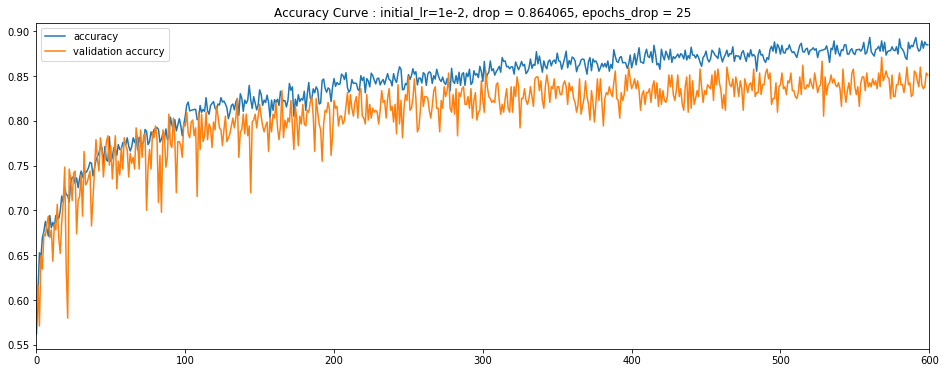

In [11]:
plt.figure(num=None, figsize=(16, 6))

plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accurcy')

plt.legend()
plt.title('Accuracy Curve : initial_lr=1e-2, drop = 0.864065, epochs_drop = 25')
plt.xlim(0, EPOCHS)
plt.show()

### Momentum

In [9]:
from util.custom_callbacks import step_decay_25_864065

momentum_list = [0.5,0.9,0.98]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 700

In [10]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay_25_864065)
lr_history_callback = StepDecayHistoryCallback()

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
callback_list = [lrate_callback, tb_callback, skipLogger_callback, lr_history_callback]

In [11]:
for momentum_i in momentum_list:
    print('working with momentum : %f' % momentum_i)
    print('')
    
    sgd = optimizers.SGD(lr=0.0,momentum=momentum_i)
    model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE,
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    training_time_dict[str(momentum_i)] = time.time() - start
    learning_history_dict[str(momentum_i)] = history
    out_of_set_test_dict[str(momentum_i)] = get_oos_test_accuracy(model)
    lr_dict[str(momentum_i)] = lr_history_callback.lr
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)

working with momentum : 0.500000



W0903 16:45:59.344269 139874400204608 deprecation.py:323] From /home/algolaptop8/anaconda3/envs/tf2-env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch =    0    loss = 0.666527    accuracy = 0.60    val_loss = 0.662479    val_accuracy = 0.64
epoch =   25    loss = 0.502722    accuracy = 0.76    val_loss = 0.524734    val_accuracy = 0.78
epoch =   50    loss = 0.462365    accuracy = 0.79    val_loss = 0.504378    val_accuracy = 0.76
epoch =   75    loss = 0.425560    accuracy = 0.81    val_loss = 0.467094    val_accuracy = 0.78
epoch =  100    loss = 0.410291    accuracy = 0.81    val_loss = 0.441374    val_accuracy = 0.83
epoch =  125    loss = 0.400920    accuracy = 0.82    val_loss = 0.458901    val_accuracy = 0.81
epoch =  150    loss = 0.375771    accuracy = 0.83    val_loss = 0.443928    val_accuracy = 0.81
epoch =  175    loss = 0.363826    accuracy = 0.84    val_loss = 0.377055    val_accuracy = 0.85
epoch =  200    loss = 0.353724    accuracy = 0.85    val_loss = 0.440303    val_accuracy = 0.82
epoch =  225    loss = 0.355367    accuracy = 0.84    val_loss = 0.444876    val_accuracy = 0.82
epoch =  250    loss = 0.34244

epoch =  100    loss = 0.596964    accuracy = 0.70    val_loss = 0.649530    val_accuracy = 0.68
epoch =  125    loss = 0.577693    accuracy = 0.71    val_loss = 0.623995    val_accuracy = 0.70
epoch =  150    loss = 0.581513    accuracy = 0.72    val_loss = 0.650436    val_accuracy = 0.68
epoch =  175    loss = 0.555539    accuracy = 0.72    val_loss = 0.611761    val_accuracy = 0.66
epoch =  200    loss = 0.556902    accuracy = 0.73    val_loss = 0.568461    val_accuracy = 0.75
epoch =  225    loss = 0.548275    accuracy = 0.73    val_loss = 0.587010    val_accuracy = 0.72
epoch =  250    loss = 0.542066    accuracy = 0.73    val_loss = 0.583328    val_accuracy = 0.72
epoch =  275    loss = 0.547795    accuracy = 0.72    val_loss = 0.577106    val_accuracy = 0.73
epoch =  300    loss = 0.534371    accuracy = 0.75    val_loss = 0.571176    val_accuracy = 0.74
epoch =  325    loss = 0.543467    accuracy = 0.73    val_loss = 0.577279    val_accuracy = 0.74
epoch =  350    loss = 0.53456

In [12]:
training_time_dict

{'0.5': 3967.5021634101868,
 '0.9': 3967.094863176346,
 '0.98': 3965.0130717754364}

In [13]:
out_of_set_test_dict

{'0.5': (0.85611427, 0.05358002),
 '0.9': (0.86716115, 0.054970756),
 '0.98': (0.7317273, 0.07030446)}

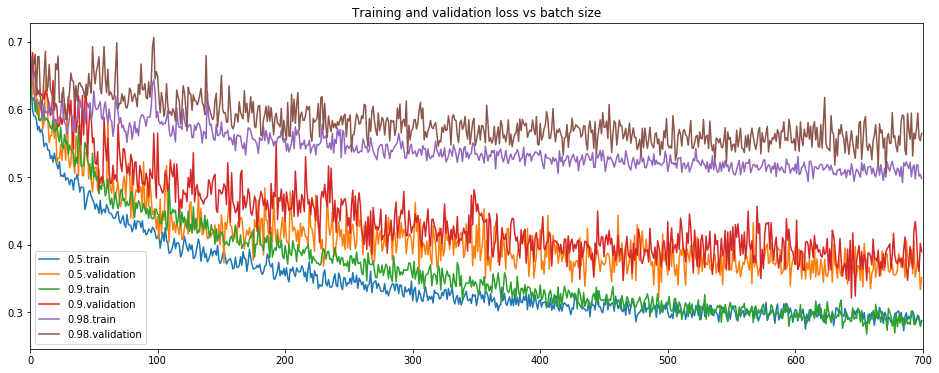

In [14]:
plt.figure(num=None, figsize=(16, 6))

for momentum,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= momentum +'.train')
    plt.plot(training_history.history['val_loss'], label= momentum + '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

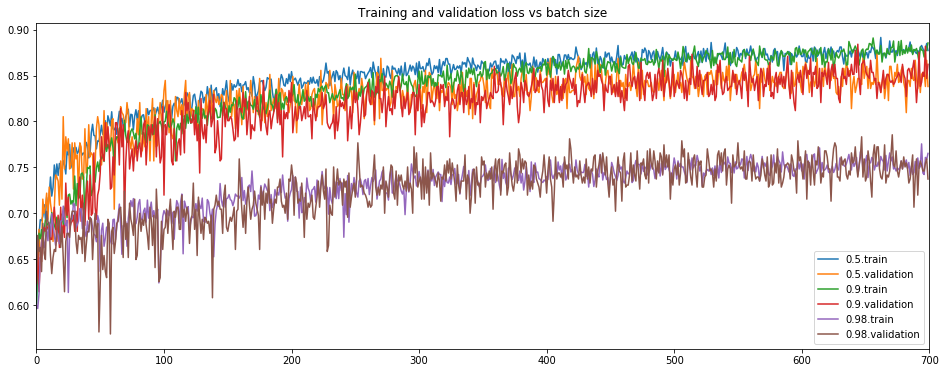

In [15]:
plt.figure(num=None, figsize=(16, 6))

for momentum,training_history in learning_history_dict.items():
    plt.plot(training_history.history['accuracy'], label= momentum +'.train')
    plt.plot(training_history.history['val_accuracy'], label= momentum + '.validation')

plt.legend()
plt.title('Training and validation accuracy vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

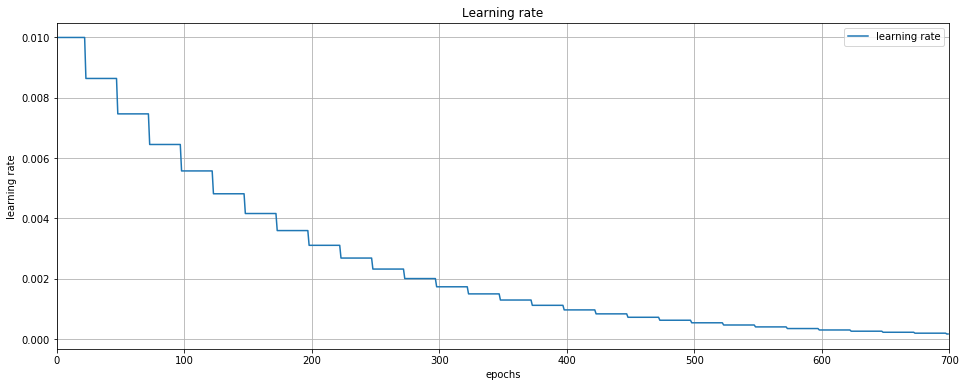

In [17]:
plt.figure(figsize=(16, 6))
plt.plot(lr_dict['0.5'], label='learning rate')
plt.xlabel("epochs")
plt.xlim(0, EPOCHS)
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()

### Nestrov parameter

In [18]:
from util.custom_callbacks import step_decay_25_864065

momentum_list = [0.5,0.9,0]
learning_history_dict = {}
training_time_dict = {}
out_of_set_test_dict = {}
lr_dict = {}
EPOCHS = 700

In [19]:
!rm -rf ./logs/
skipLogger_callback = SkipLoggerCallback(n=25)

lrate_callback = LearningRateScheduler(step_decay_25_864065)
lr_history_callback = StepDecayHistoryCallback()

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
callback_list = [lrate_callback, tb_callback, skipLogger_callback, lr_history_callback]

In [20]:
for momentum_i in momentum_list:
    print('working with momentum : %f' % momentum_i)
    print('')
    
    sgd = optimizers.SGD(lr=0.0,momentum=momentum_i,nesterov=True)
    model = define_model_architecture_64_32_16(sgd_optimizer=sgd)
    
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    start = time.time()
    history = model.fit_generator(generator = train_batches, steps_per_epoch=train_batches.samples/BATCH_SIZE, 
                                  validation_data = validation_batches, validation_steps = validation_batches.samples/BATCH_SIZE,
                                  epochs=EPOCHS, verbose=0, workers=4, callbacks = callback_list)
    training_time_dict[str(momentum_i)] = time.time() - start
    learning_history_dict[str(momentum_i)] = history
    out_of_set_test_dict[str(momentum_i)] = get_oos_test_accuracy(model)
    lr_dict[str(momentum_i)] = lr_history_callback.lr
    test_loss, test_accuracy = model.evaluate_generator(test_batches, workers=4, verbose=0) 
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))    
    print('-'*120)

working with momentum : 0.500000

epoch =    0    loss = 0.675341    accuracy = 0.58    val_loss = 0.693498    val_accuracy = 0.57
epoch =   25    loss = 0.522998    accuracy = 0.75    val_loss = 0.564474    val_accuracy = 0.72
epoch =   50    loss = 0.465552    accuracy = 0.79    val_loss = 0.511793    val_accuracy = 0.77
epoch =   75    loss = 0.444139    accuracy = 0.79    val_loss = 0.461856    val_accuracy = 0.82
epoch =  100    loss = 0.414672    accuracy = 0.81    val_loss = 0.441874    val_accuracy = 0.80
epoch =  125    loss = 0.395677    accuracy = 0.83    val_loss = 0.435579    val_accuracy = 0.81
epoch =  150    loss = 0.384797    accuracy = 0.83    val_loss = 0.440198    val_accuracy = 0.79
epoch =  175    loss = 0.366393    accuracy = 0.84    val_loss = 0.441754    val_accuracy = 0.80
epoch =  200    loss = 0.342765    accuracy = 0.85    val_loss = 0.432419    val_accuracy = 0.82
epoch =  225    loss = 0.355104    accuracy = 0.84    val_loss = 0.409075    val_accuracy = 0

KeyboardInterrupt: 

In [21]:
training_time_dict

{'0.5': 4039.048728466034, '0.9': 4059.985673904419}

In [22]:
out_of_set_test_dict

{'0.5': (0.8620605, 0.051556397), '0.9': (0.8723496, 0.04349077)}

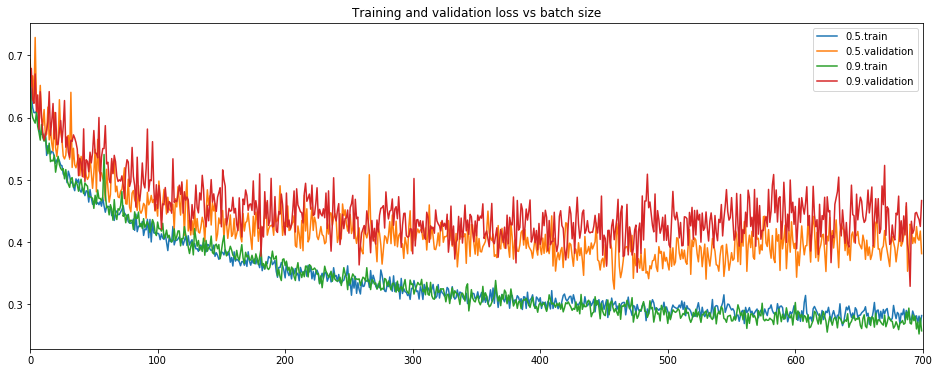

In [23]:
plt.figure(num=None, figsize=(16, 6))

for momentum,training_history in learning_history_dict.items():
    plt.plot(training_history.history['loss'], label= momentum +'.train')
    plt.plot(training_history.history['val_loss'], label= momentum + '.validation')

plt.legend()
plt.title('Training and validation loss vs batch size')
plt.xlim(0, EPOCHS)
plt.show()

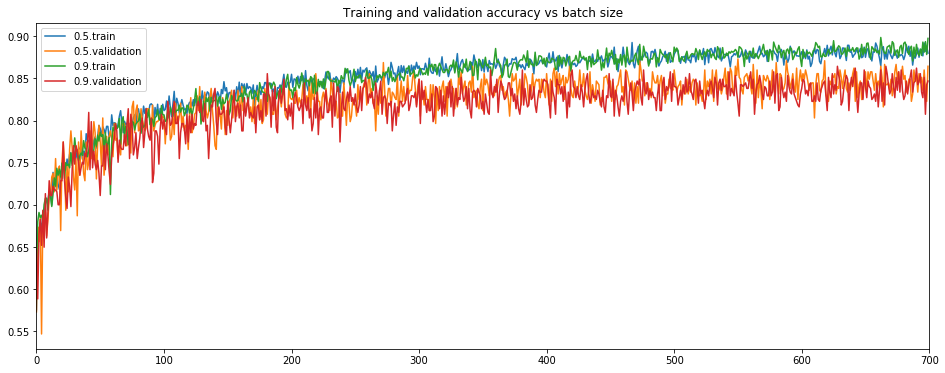

In [24]:
plt.figure(num=None, figsize=(16, 6))

for momentum,training_history in learning_history_dict.items():
    plt.plot(training_history.history['accuracy'], label= momentum +'.train')
    plt.plot(training_history.history['val_accuracy'], label= momentum + '.validation')

plt.legend()
plt.title('Training and validation accuracy vs batch size')
plt.xlim(0, EPOCHS)
plt.show()